In [217]:
import pandas as pd
import plotly as ply
import numpy as np
import matplotlib.pyplot as plt
from user_defined_function.functions import *
from IPython.display import clear_output

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_yaml

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

image_directory= 'image_folder/'
data_directory = 'Original_data/survey_results_public.csv'

In [214]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []        
        self.fig = plt.figure()                
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### load original data

In [5]:
df = pd.read_csv(data_directory)
df.head()

Respondent                                       Professional  \
0           1                                            Student   
1           2                                            Student   
2           3                             Professional developer   
3           4  Professional non-developer who sometimes write...   
4           5                             Professional developer   

                ProgramHobby         Country      University  \
0                  Yes, both   United States              No   
1                  Yes, both  United Kingdom  Yes, full-time   
2                  Yes, both  United Kingdom              No   
3                  Yes, both   United States              No   
4  Yes, I program as a hobby     Switzerland              No   

                         EmploymentStatus  \
0  Not employed, and not looking for work   
1                      Employed part-time   
2                      Employed full-time   
3                      Employed full-time   
4                      Employed full-time   

                                     FormalEducation  \
0                                   Secondary school   
1  Some college/university study without earning ...   
2                                  Bachelor's degree   
3                                    Doctoral degree   
4                                    Master's degree   

                                  MajorUndergrad  \
0                                            NaN   
1       Computer science or software engineering   
2       Computer science or software engineering   
3  A non-computer-focused engineering discipline   
4       Computer science or software engineering   

                                          HomeRemote  \
0                                                NaN   
1              More than half, but not all, the time   
2  Less than half the time, but at least one day ...   
3  Less than half the time, but at least one day ...   
4                                              Never   

                CompanySize  ... StackOverflowMakeMoney Gender  \
0                       NaN  ...      Strongly disagree   Male   
1        20 to 99 employees  ...      Strongly disagree   Male   
2  10,000 or more employees  ...               Disagree   Male   
3  10,000 or more employees  ...               Disagree   Male   
4        10 to 19 employees  ...                    NaN    NaN   

  HighestEducationParents                          Race         SurveyLong  \
0             High school  White or of European descent  Strongly disagree   
1       A master's degree  White or of European descent     Somewhat agree   
2   A professional degree  White or of European descent     Somewhat agree   
3       A doctoral degree  White or of European descent              Agree   
4                     NaN                           NaN                NaN   

  QuestionsInteresting QuestionsConfusing InterestedAnswers    Salary  \
0       Strongly agree           Disagree    Strongly agree       NaN   
1       Somewhat agree           Disagree    Strongly agree       NaN   
2                Agree           Disagree             Agree  113750.0   
3                Agree     Somewhat agree    Strongly agree       NaN   
4                  NaN                NaN               NaN       NaN   

   ExpectedSalary  
0             NaN  
1         37500.0  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 154 columns]

In [12]:
df[Rank2_feature[0]].unique()

array(['Very important', nan, 'Somewhat important', 'Important',
       'Not very important', 'Not at all important'], dtype=object)

In [6]:
### Input column 과 output column에 대해 분석
Rank_feature = ['ProblemSolving','BuildingThings','LearningNewTech','BoringDetails',
                'JobSecurity','DiversityImportant','AnnoyingUI','FriendsDevelopers','RightWrongWay',
                'UnderstandComputers','SeriousWork','InvestTimeTools','WorkPayCare','ChallengeMyself','CompetePeers','ChangeWorld',
               ]
# array(['Strongly agree', nan, 'Agree', 'Somewhat agree', 'Disagree',
#        'Strongly disagree'], dtype=object)
Rank2_feature = ['AssessJobRole','AssessJobRemote','AssessJobProduct','AssessJobProfDevel',
                 'ImportantHiringEducation','ImportantHiringCommunication']
# array(['Very important', nan, 'Somewhat important', 'Important',
#        'Not very important', 'Not at all important'], dtype=object)
Nomial_feature = ['FormalEducation','MajorUndergrad','EducationTypes','ImportantBenefits']
total_input_features = Rank_feature+Rank2_feature+Nomial_feature
Output_feature =  ['Developer type']
Information_feature = ['CousinEducation']
### 인코딩이 필요한 칼럼 
Hot_encoding_needed = ['EducationTypes','CousinEducation','ImportantBenefits']

In [7]:
total_input_features = Rank_feature+Rank2_feature+Nomial_feature
total_input_features

['ProblemSolving',
 'BuildingThings',
 'LearningNewTech',
 'BoringDetails',
 'JobSecurity',
 'DiversityImportant',
 'AnnoyingUI',
 'FriendsDevelopers',
 'RightWrongWay',
 'UnderstandComputers',
 'SeriousWork',
 'InvestTimeTools',
 'WorkPayCare',
 'ChallengeMyself',
 'CompetePeers',
 'ChangeWorld',
 'AssessJobRole',
 'AssessJobRemote',
 'AssessJobProduct',
 'AssessJobProfDevel',
 'ImportantHiringEducation',
 'ImportantHiringCommunication',
 'FormalEducation',
 'MajorUndergrad',
 'EducationTypes',
 'ImportantBenefits']

In [6]:
EducationTypes_df = Hot_encoding(df,'EducationTypes',dropna = False)
EducationTypes_df.to_csv('Dataframe_folder/EducationTypes_df_HE.csv')
ImportantBenefits_df = Hot_encoding(df,'ImportantBenefits',dropna = False)
ImportantBenefits_df.to_csv('Dataframe_folder/ImportantBenefits_df_HE.csv')
CousinEducation_df = Hot_encoding(df,'CousinEducation',dropna = False)
CousinEducation_df.to_csv('Dataframe_folder/CousinEducation_df_HE.csv')


In [113]:
Output_data = pd.read_csv('Dataframe_folder/DeveloperType_HE.csv',index_col = 0)
Output_data = Output_data[Output_data.sum(axis = 1)==1]
Output_data.sum(axis = 0)

Desktop applications developer                            1433
Embedded applications/devices developer                    664
Mobile developer                                          1556
DevOps specialist                                          192
Web developer                                            10683
Other                                                     1174
Database administrator                                      73
Systems administrator                                       31
Graphic designer                                             6
Developer with a statistics or mathematics background      485
Data scientist                                             249
Graphics programming                                        55
Quality assurance engineer                                 102
Machine learning specialist                                 44
dtype: int64

In [114]:
Output_data = Output_data[['Mobile developer','Web developer','Desktop applications developer']]
Output_data = Output_data[Output_data.sum(axis = 1)==1]
Output_data.shape

(13672, 3)

In [82]:
EducationTypes_df = pd.read_csv('Dataframe_folder/EducationTypes_df_HE.csv',index_col = 0)
ImportantBenefits_df = pd.read_csv('Dataframe_folder/ImportantBenefits_df_HE.csv',index_col = 0)
Dummy_df = dict()
for feature in total_input_features:
    Dummy_df[feature] = pd.get_dummies(df[feature])
Dummy_df['EducationTypes'] = EducationTypes_df
Dummy_df['ImportantBenefits'] = ImportantBenefits_df

In [83]:
for key in Dummy_df.keys():
    Dummy_df[key] = Dummy_df[key].loc[Output_data.index]

In [84]:
Dummy_df

{'ProblemSolving':        Agree  Disagree  Somewhat agree  Strongly agree  Strongly disagree
 7          0         0               0               0                  0
 11         0         0               0               0                  0
 13         0         0               0               0                  0
 15         0         0               0               1                  0
 16         1         0               0               0                  0
 ...      ...       ...             ...             ...                ...
 51372      0         0               0               0                  0
 51374      1         0               0               0                  0
 51377      0         0               0               0                  0
 51382      0         0               0               1                  0
 51384      0         0               0               1                  0
 
 [13672 rows x 5 columns],
 'BuildingThings':        Agree  Disagree  Somewhat a

In [85]:
dummy_df_list = []
for key in Dummy_df.keys():
    dummy_df_list.append(Dummy_df[key])
Input_data = np.concatenate(dummy_df_list,axis = 1)

In [173]:
np.unique(np.argmax(Output_data.values,axis = 1),return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 1556, 10683,  1433], dtype=int64))

In [174]:
labels = np.argmax(Output_data.values,axis = 1)

In [194]:
np.save("numpy_array_data/Input_data",Input_data)
np.save("numpy_array_data/label_data",labels)

In [175]:
trainX, testX, trainY, testY = train_test_split(Input_data, labels, test_size=0.2, random_state=42)

In [176]:
print("trainX :",trainX.shape)
print("trainX :",trainY.shape)
print("trainX :",testX.shape)
print("trainX :",testY.shape)

trainX : (10937, 161)
trainX : (10937,)
trainX : (2735, 161)
trainX : (2735,)


In [177]:
def getModel(arr):
    model=Sequential()
    for i in range(len(arr)):
        if i!=0 and i!=len(arr)-1:
            if i==1:
                model.add(Dense(arr[i],input_dim=arr[0],kernel_initializer='normal', activation='relu'))
            else:
                model.add(Dense(arr[i],activation='relu'))
    model.add(Dense(arr[-1],kernel_initializer='normal',activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    # catego
    return model
Original_Model=getModel([161,50,3])

W1007 12:02:51.095944  4748 legend.py:1282] No handles with labels found to put in legend.


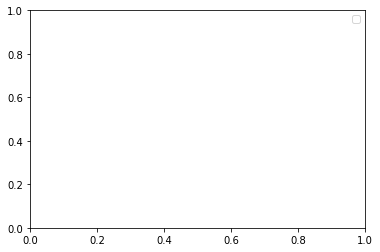

In [181]:
### Artificial neuron network 
firstModel.fit(np.array(trainX),np.array(trainY),epochs=40,callbacks=[plot_losses])

In [216]:
### XGBoost
XGBmodel = XGBClassifier()
XGBmodel.fit(trainX,trainY)
predictions = XGBmodel.predict(testX)

In [228]:
print ("accuracy" , metrics.accuracy_score(testY, predictions))
print(np.unique(testY,return_counts = True)[1][1]/np.sum(np.unique(testY,return_counts = True)[1]))

accuracy 0.7886654478976234
0.7886654478976234


In [227]:
np.unique(predictions,return_counts = True)

(array([1], dtype=int64), array([2735], dtype=int64))

In [225]:
# 0 = 'Mobile'
# 1 = 'Web'
# 2 = 'Desk'
Mobile =0
Web = 0
Desk = 0
np.unique(testY,return_counts = True)[1]
for i in range(predictions.shape[0]) :
    if testY[i] == predictions[i] :
        if testY[i] == 0 :
            Mobile += 1
        elif testY[i] == 1 :
            Web += 1
        else :
            Desk += 1
print("Mobile accuracy :", Mobile/np.unique(testY,return_counts = True)[1][0]*100)
print("Web accuracy :", Web/np.unique(testY,return_counts = True)[1][1]*100)
print("Desk accuracy :", Desk/np.unique(testY,return_counts = True)[1][2]*100)
        

Mobile accuracy : 0.0
Web accuracy : 100.0
Desk accuracy : 0.0


In [183]:
model_yaml = firstModel.to_yaml()
with open("Model_folder/ANN_model_unimbal.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
firstModel.save_weights("Model_folder/model_3_unimbal.h5")

In [184]:
score = firstModel.evaluate(testX, testY, verbose=0)
score

[0.9268285886025298, 0.7378427788587986]

In [190]:
predY= firstModel.predict(testX)
unique_elements, counts_elements = np.unique(np.argmax(predY,axis = 1),return_counts=True)
print("predYunique_elements : ",unique_elements)
print("predY value's count : ",counts_elements)
print("real data value's count : ",np.unique(testY,return_counts = True))

predYunique_elements :  [0 1 2]
predY value's count :  [ 133 2491  111]
real data value's count :  (array([0, 1, 2], dtype=int64), array([ 304, 2157,  274], dtype=int64))


# 데이터가 비정형 데이터 이므로 under sampling, over sampling을 시행.

In [237]:
rus = RandomUnderSampler(random_state=0)
X_Undersample, y_Undersample = rus.fit_resample(Input_data, labels)
print("X_Undersample's shape : ",X_Undersample.shape)
print("y_Undersample's shape : ",y_Undersample.shape)

X_Undersample's shape :  (4299, 161)
y_Undersample's shape :  (4299,)


In [238]:
ros = RandomOverSampler(random_state=0)
X_Oversample, y_Oversample = ros.fit_resample(Input_data,labels)
print("X_Undersample's shape : ",X_Oversample.shape)
print("y_Undersample's shape : ",y_Oversample.shape)

X_Undersample's shape :  (32049, 161)
y_Undersample's shape :  (32049,)


# 먼저 Under sampling data를 이용하여 모델 테스트

In [239]:
UtrainX, UtestX, UtrainY, UtestY = train_test_split(X_Undersample, y_Undersample, test_size=0.2, random_state=42)
print("trainX :",UtrainX.shape)
print("trainX :",UtrainY.shape)
print("trainX :",UtestX.shape)
print("trainX :",UtestY.shape)

trainX : (3439, 161)
trainX : (3439,)
trainX : (860, 161)
trainX : (860,)


In [240]:
### XGBoost
Unbal_XGBmodel = XGBClassifier()
Unbal_XGBmodel.fit(UtrainX,UtrainY)
Unbal_predictions = Unbal_XGBmodel.predict(UtestX)

In [241]:
# 0 = 'Mobile'
# 1 = 'Web'
# 2 = 'Desk'
Mobile =0
Web = 0
Desk = 0
np.unique(UtestY,return_counts = True)[1]
for i in range(Unbal_predictions.shape[0]) :
    if UtestY[i] == Unbal_predictions[i] :
        if UtestY[i] == 0 :
            Mobile += 1
        elif UtestY[i] == 1 :
            Web += 1
        else :
            Desk += 1
print("Mobile accuracy :", Mobile/np.unique(UtestY,return_counts = True)[1][0]*100)
print("Web accuracy :", Web/np.unique(UtestY,return_counts = True)[1][1]*100)
print("Desk accuracy :", Desk/np.unique(UtestY,return_counts = True)[1][2]*100)

Mobile accuracy : 50.641025641025635
Web accuracy : 28.368794326241137
Desk accuracy : 50.37593984962406


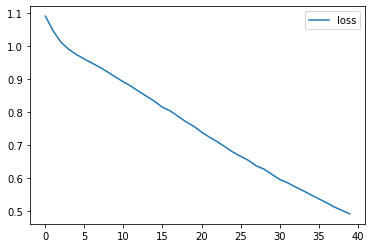

In [242]:
Unbal_Model=getModel([161,50,3])
Unbal_Model.fit(np.array(UtrainX),np.array(UtrainY),epochs=40,callbacks=[plot_losses])

In [243]:
# 생성된 모델 저장
model_yaml = Unbal_Model.to_yaml()
with open("Model_folder/ANN_model_under.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
Unbal_Model.save_weights("Model_folder/model_3_under.h5")

In [244]:
predY= Unbal_Model.predict(testX)
unique_elements, counts_elements = np.unique(np.argmax(predY,axis = 1),return_counts=True)
print("predY unique_elements : ",unique_elements)
print("predY value's count : ",counts_elements)
print("real data value's count : ",np.unique(testY,return_counts=True))

predYunique_elements :  [0 1 2]
predY value's count :  [941 973 821]
real data value's count :  (array([0, 1, 2], dtype=int64), array([ 304, 2157,  274], dtype=int64))


#  Over sampling data를 이용하여 모델 테스트

In [246]:
OtrainX, OtestX, OtrainY, OtestY = train_test_split(X_Oversample, y_Oversample , test_size=0.2, random_state=42)
print("trainX :",OtrainX.shape)
print("trainX :",OtrainY.shape)
print("trainX :",OtestX.shape)
print("trainX :",OtestY.shape)

trainX : (25639, 161)
trainX : (25639,)
trainX : (6410, 161)
trainX : (6410,)


In [272]:
Over_XGBmodel = XGBClassifier()
Over_XGBmodel.fit(OtrainX,OtrainY)
Over_predictions = Over_XGBmodel.predict(testX)

In [275]:
Mobile =0
Web = 0
Desk = 0
testY
for i in range(Over_predictions.shape[0]) :
    if testY[i] ==Over_predictions[i] :
        if testY[i] == 0 :
            Mobile += 1
        elif testY[i] == 1 :
            Web += 1
        else :
            Desk += 1
print("Mobile accuracy :", Mobile/np.unique(testY,return_counts = True)[1][0]*100)
print("Web accuracy :", Web/np.unique(testY,return_counts = True)[1][1]*100)
print("Desk accuracy :", Desk/np.unique(testY,return_counts = True)[1][2]*100)

Mobile accuracy : 60.526315789473685
Web accuracy : 41.02920723226704
Desk accuracy : 64.96350364963503


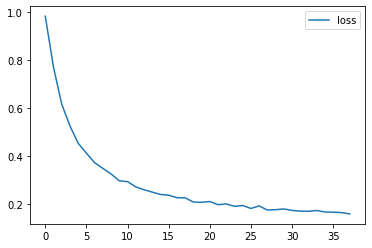

In [281]:
Over_Model=getModel([161,50,50,50,50,50,3])
Over_Model.fit(np.array(OtrainX),np.array(OtrainY),epochs=38,callbacks=[plot_losses])

In [277]:
# 생성된 모델 저장
model_yaml = Over_Model.to_yaml()
with open("Model_folder/ANN_model_over.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
Over_Model.save_weights("Model_folder/model_3_over.h5")

In [282]:
score = Over_Model.evaluate(testX, testY, verbose=0)
score

[0.43700289734702225, 0.8453382084095064]

In [283]:
predY= Over_Model.predict(testX)
unique_elements, counts_elements = np.unique(np.argmax(predY,axis = 1),return_counts=True)
print("predYunique_elements : ",unique_elements)
print("predY value's count : ",counts_elements)
print("real data value's count : ",np.unique(testY,return_counts=True))

predYunique_elements :  [0 1 2]
predY value's count :  [ 554 1777  404]
real data value's count :  (array([0, 1, 2], dtype=int64), array([ 304, 2157,  274], dtype=int64))


In [284]:
print(np.argmax(predY,axis = 1))
print(testY)
Mobile =0
Web = 0
Desk = 0
testY
for i in range(predY.shape[0]) :
    if testY[i] == np.argmax(predY,axis = 1)[i] :
        if testY[i] == 0 :
            Mobile += 1
        elif testY[i] == 1 :
            Web += 1
        else :
            Desk += 1
print("Mobile accuracy :", Mobile/np.unique(testY,return_counts = True)[1][0]*100)
print("Web accuracy :", Web/np.unique(testY,return_counts = True)[1][1]*100)
print("Desk accuracy :", Desk/np.unique(testY,return_counts = True)[1][2]*100)

[1 1 1 ... 0 1 2]
[1 1 1 ... 0 1 2]
Mobile accuracy : 96.71052631578947
Web accuracy : 81.8266110338433
Desk accuracy : 92.33576642335767


In [348]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_X  = pca.fit_transform(X_Oversample)  

In [349]:
pca_X.shape

(32049, 3)

In [350]:
x = np.squeeze(pca_X[np.where(y_Oversample==0),0])
x.shape

(10683,)

In [351]:
import plotly.graph_objects as go
import numpy as np

# Helix equation

testY  = y_Oversample
fig = go.Figure()
x = np.squeeze(pca_X[np.where(testY==0),0])
y = np.squeeze(pca_X[np.where(testY==0),1])
z = np.squeeze(pca_X[np.where(testY==0),2])
fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',name = 'Mobile accuracy',marker = dict(size = 1,color = 0, line_color='rgb(140, 140, 170)')))
x = np.squeeze(pca_X[np.where(testY==1),0])
y = np.squeeze(pca_X[np.where(testY==1),1])
z = np.squeeze(pca_X[np.where(testY==1),2])
fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',name ='Web accuracy' ,marker = dict(size = 1,color = 100, line_color='rgb(140, 140, 170)')))
x = np.squeeze(pca_X[np.where(testY==2),0])
y = np.squeeze(pca_X[np.where(testY==2),1])
z = np.squeeze(pca_X[np.where(testY==2),2])
fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                  mode='markers',name ='Desk accuracy' ,marker = dict(size = 1,color = 255, line_color='rgb(140, 140, 170)')))

fig.show()

In [333]:
pca_X[np.where(testY==0),0].shape

(1, 304)

In [332]:
x.shape

(100,)

In [57]:
# Load 하는 방법
yaml_file = open("Model_folder/ANN_model.yaml", 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("Model_folder/model.h5")
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

In [ ]:
class create_classification_df(x,y,models = ['SVM','NB','XGboost','KNeighbors','Logistic','SGD']
                             , performance = ['f1-score','recall','Accuracy','precise'], binomial = False) :
    
    def __init__(self, x,y,models = ['SVM','NB','XGboost','KNeighbors','Logistic','SGD']
                             , performance = ['f1-score','recall','Accuracy','precise'], binomial = False)):
        self.x = x
        self.y = y
        self.models = models
        self.performance = performance 
        self.binomial = binomial
        self.Set_xgboost_parameter()
    def Set_xgboost_parameter(self,objective = 'multi:softprob',eta = 0.1,max_depth = 5, num_class = 3, subsample = 0.8,
                             colsample_bytree = 0.8, eval_metric = 'mlogloss',min_child_weight= 10,reg_alpha = 1.5,
                             reg_lambda = 5, scale_pos_weight = 1, n_thread = -1) :
        if 'XGboost' in self.models :
            self.params = {'objective': objective,
                      'learning_rate':eta,
                      'max_depth': max_depth,
                      'num_class': num_class,
                      'subsample': subsample,
                      'colsample_bytree': colsample_bytree,
                      'eval_metric': eval_metric,
                      'min_child_weight': min_child_weight,
                      'reg_alpha': reg_alpha, 
                      'reg_lambda' : reg_lambda,
                      'scale_pos_weight' : scale_pos_weight,          
                      'n_thread':n_thread }
        else:
            print("no xgboost here")
  
    def construct_model(self) :
        model_dict = dict()
        if binomial == True:
            performance.append('AUC-ROC')
        for model in models :
            if model == 'SVM':
                model_dict[model] = SVC(kernel = 'rbf',random_state = 10)
            elif model == 'NB' :
                model_dict[model] = MultinomialNB()
            elif model == 'XGboost' :
                model_dict[model] = xgb.train(self.params,dtrain,n_rounds,early_stopping_rounds=early_stop,verbose_eval=10)

kf =StratifiedKFold(n_splits=5)
for train_index,test_index in kf.split(Input_data): 
    xtr,xvl = Input_data[train_index], Input_data[test_index]
    ytr,yvl = Output_data[train_index], Output_data[test_index]
    
    mNB.fit(xtr,ytr)
    y_mNB = mNB.predict(xvl)
    cv_score.append(log_loss(yvl,mNB.predict_proba(xvl)))    
    pred_test_full += mNB.predict_proba(X_test_cv)